<h1 align="center">Regarding plot summaries</h1>

<h2 align="center">In this notebook, we will present our idea on one plot summary (Movie ID = 23890098) in order to give examples. We will apply the same ideas to all the summaries (present in the plot_summaries.txt)</h2>


### The exercise here is to use the movies plot summaries in order to find a relationship or an insight leading us to the financial success of a movie. The problem is to try to identify which kind of plotline maximizes revenue.

A first idea, (which is more like a flex I have to agree) was to visualize the most common words in the format of clouds of words. This turned to be useful because it made us realize that the most common words were often the names. (As you can see on the code below when we updated the stopwords, adding the names of the characters).

By the way, trying this method at first made us realize that character names are really common in summaries. One way we used to deal with that, is that, as you will see in the continuity of the 'problem', we also got rid of words starting with an uppercase letter (when converting our text to a list of the words).

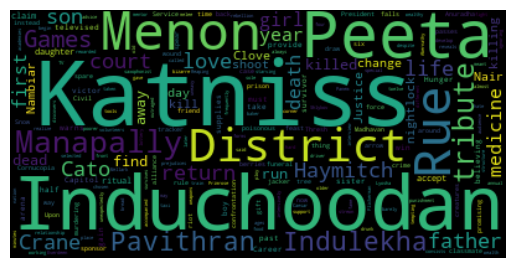

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#STOPWORDS.update({"Peeta", "Haymitch", "Cato", "Katniss", "Menon", "Rue", "District", "tribute", "Manapally", "Indulekha", "Pavithran"})
#"Induchoodan"
# read text from file and store in a variable
with open("/Users/reds/Desktop/essai.txt") as file:
    data = file.read()

# create wordcloud using data
wordcloud = WordCloud().generate(data)

# show wordcloud using matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

As you can imagine, the idea above is not useful..
Another idea was to only consider the words with the highest frequency. This poses a problem as to how to define a "high frequency". In some texts we could find that a high frequency would mean that a word is present more than 4 times, while in other texts it could be only more that 2 times... which already poses a problem, if we want to generalize it.
As you can see below an example where we only kept words which appeared 3 or more times in the summary.

In [19]:
import re
 
frequency = {}
document_text = open('/Users/reds/Desktop/essai.txt', 'r')
text_string = document_text.read()#.lower()
match_pattern = re.findall(r"[\w']+", text_string)
match_pattern = [m for m in match_pattern if not m.istitle()]
match_pattern = [m for m in match_pattern if not m.isdigit()]

for word in match_pattern:
    if word in stop_words:
        continue
    count = frequency.get(word,0)
    frequency[word] = count + 1
    
x = []
y = []
frequency_list = frequency.keys()
# frequency of words
for words in frequency_list:
    if(frequency[words] > 2):
        x.append(words)
        y.append(frequency[words])
        print(words, frequency[words])

love 4
girl 3
tributes 4
death 3
first 3
son 4
tribute 3
medicine 3
killed 3
away 3
dead 3
killing 3
nightlock 3
life 4
daughter 3
returns 3
father 4
court 4


We then had this idea of making that bar plot to highlight the most frequent words:

In [20]:
print('x = ', x)
print('y = ', y)

x =  ['love', 'girl', 'tributes', 'death', 'first', 'son', 'tribute', 'medicine', 'killed', 'away', 'dead', 'killing', 'nightlock', 'life', 'daughter', 'returns', 'father', 'court']
y =  [4, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4]


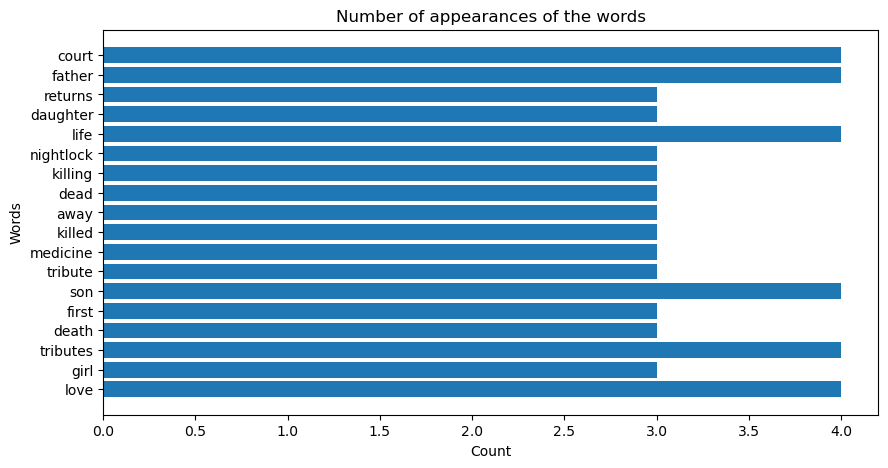

In [21]:
plt.figure(figsize=(10, 5))
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Number of appearances of the words')
p = plt.barh(x,y)
#p.invert_yaxis()
#sns.countplot(data=df, y=x)

### Final idea:

Remember that the goal here is to try to determine whether the text is positive, negative, or neutral.
Referring to HW1, we thought of using the english lexicon summary, using positive-words.txt and negative-words.txt files. After thorough research on the internet and trying a few libraries, this turned out to be more complete one.

In [22]:
negative = pd.read_csv('/Users/reds/Desktop/negative-words.txt',encoding_errors='ignore',delimiter='\t',header=None,skiprows=30,names=['words'])
positive = pd.read_csv('/Users/reds/Desktop/positive-words.txt',encoding_errors='ignore',delimiter='\t',header=None,skiprows=30,names=['words'])
negative_list = negative.stack().tolist()
positive_list = positive.stack().tolist()

We therefore perform an intersection between the list of positive (resp. negative) words and the list of words of our summary.

In [23]:
len_neg = len(list(set(frequency_list) & set(negative_list)))
len_pos = len(list(set(frequency_list) & set(positive_list)))
len_total = len(frequency_list)
print("Number of positive words:", len_neg)
print("Number of negative words:", len_pos)
print("Number of words:", len_total)

Number of positive words: 53
Number of negative words: 24
Number of words: 447


We now want to find a metric to determine if it is positive, negative, or neutral, what we would call our "sentiment score":
- Method 1: Calculate absolute score by using positive count-negative count
    ##### $$ Degree = number(positive) - number(negative) $$
    This is a direct and simple calculation of how positive/negative the review is. The advantage is that it is straightforward and simple to understand. However, the score may favor longer reviews because they tend to have more counts of positive/negative words even they have the same sentiment.
- #### Our method : Normalise the score by the length of the summary:
    ##### $$ Degree = \frac{number(positive) - number(negative)}{number(words)} $$
    This gives us a result between -1 and 1.

In [24]:
# Calculation of frequency:
# Degree of p/n = (pos - neg)/total_words
degree = (len_pos-len_neg)/len_total
print("degree =", degree)

degree = -0.06487695749440715


Once we have this degree of positivity / negativity for each plot summary. We will find a correlation with the profit of the movie in order to determine what kind of "emotion" would most likely lead to a successful movie. In other terms, what is the most common emotion in financially successful movies.

# Now let's do for all movies:

In [74]:
colnames=["Wikipedia Movie ID","Summary"]
df_plot=pd.read_csv('/Users/reds/Desktop/Proj/MovieSummaries/plot_summaries.txt',names=colnames, sep="\t")
df_plot.head()

,Wikipedia Movie ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


### Algorithm to compute emotion degree for a summary:

In [75]:
def compute_deg(text_string):
    frequency = {}
    
    match_pattern = re.findall(r"[\w']+", text_string)
    match_pattern = [m for m in match_pattern if not m.istitle()]
    match_pattern = [m for m in match_pattern if not m.isdigit()]

    for word in match_pattern:
        if word in stop_words:
            continue
        count = frequency.get(word,0)
        frequency[word] = count + 1

    frequency_list = frequency.keys()
    len_neg = len(list(set(frequency_list) & set(negative_list)))
    len_pos = len(list(set(frequency_list) & set(positive_list)))
    len_total = len(frequency_list)
    #print("Number of positive words:", len_neg)
    #print("Number of negative words:", len_pos)
    #print("Number of words:", len_total)
    if(len_total==0):
        degree = 0
    else:
        degree = (len_pos-len_neg)/len_total
    #print("degree =", degree)
    return degree

In [76]:
list_scores = []
for index in range(0, len(df_plot)):
    score = compute_deg(df_plot['Summary'][index])
    list_scores.append(score)

In [77]:
list_scores

[-0.21428571428571427,
 -0.05714285714285714,
 -0.07738095238095238,
 -0.014084507042253521,
 -0.05027932960893855,
 -0.08108108108108109,
 -0.07758620689655173,
 -0.03587443946188341,
 -0.03755868544600939,
 -0.12244897959183673,
 -0.02727272727272727,
 -0.1388888888888889,
 -0.038461538461538464,
 -0.08064516129032258,
 -0.002688172043010753,
 -0.15384615384615385,
 0.0,
 -0.04411764705882353,
 -0.04516129032258064,
 -0.05555555555555555,
 -0.10416666666666667,
 -0.03571428571428571,
 -0.043478260869565216,
 0.0,
 -0.1588235294117647,
 -0.03076923076923077,
 -0.034482758620689655,
 -0.043478260869565216,
 0.015384615384615385,
 0.0,
 -0.07692307692307693,
 -0.15384615384615385,
 -0.03773584905660377,
 -0.09615384615384616,
 -0.09134615384615384,
 -0.06711409395973154,
 -0.08783783783783784,
 -0.011904761904761904,
 0.05,
 -0.09090909090909091,
 -0.002583979328165375,
 -0.0916030534351145,
 -0.061452513966480445,
 0.0,
 -0.045454545454545456,
 -0.03278688524590164,
 0.0757575757575757

In [78]:
df_plot["Sentiment"]=list_scores

In [79]:
df_plot

,Wikipedia Movie ID,Summary,Sentiment
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",-0.214286
1,31186339,The nation of Panem consists of a wealthy Capi...,-0.057143
2,20663735,Poovalli Induchoodan is sentenced for six yea...,-0.077381
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",-0.014085
4,595909,Seventh-day Adventist Church pastor Michael Ch...,-0.050279
...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",0.000000
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",-0.064865
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,0.125000
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",-0.022472
